In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values


In [6]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
static_sd = df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values


In [7]:
from sklearn.model_selection import train_test_split, KFold

In [8]:
n_splits = 10


In [43]:
H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, 3, 2, num_iter=1200, lr=1, dis=True, cost_function='l21', H_known=None, penalty_coeff=0)


489.086493096
54.4997338987
54.3535051068


In [44]:
H_sd, A_sd, T_sd, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor, 3, 2, num_iter=1200, lr=1, dis=True, cost_function='l21', H_known=None, penalty_coeff=0)


207.62262077
26.8370823579
26.8168289784


In [11]:
pd.DataFrame(A_sd.reshape(7, 2), index=APPLIANCES_ORDER, columns=['Weather\nindependent', 'Weather\ndependent'])

,Weather independent,Weather dependent
aggregate,8.446103e+00,6.938781e+00
hvac,1.000000e-08,4.970984e+00
fridge,1.080815e+00,1.758578e-01
mw,2.020668e-01,2.559945e-03
dw,1.667051e-01,3.307430e-02
wm,9.720371e-02,1.569116e-02
oven,2.613633e-01,1.000000e-08


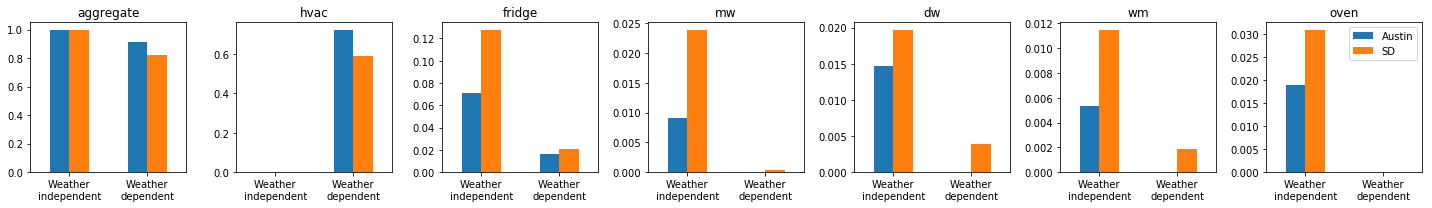

In [12]:
A_sd_flat = pd.DataFrame(A_sd.reshape(7, 2), index=APPLIANCES_ORDER, columns=['Weather\nindependent', 'Weather\ndependent'])
A_sd_flat  = A_sd_flat.div(A_sd_flat.max().max())


A_au_flat = pd.DataFrame(A_au.reshape(7, 2), index=APPLIANCES_ORDER, columns=['Weather\nindependent', 'Weather\ndependent'])
A_au_flat = A_au_flat.div(A_au_flat.max().max())

fig, ax = plt.subplots(ncols=7, figsize=(20, 3))
for col, appliance in enumerate(APPLIANCES_ORDER):
    d = pd.DataFrame({"Austin": A_au_flat.loc[appliance], "SD":A_sd_flat.loc[appliance]})
    d.plot(kind='bar',rot=0, ax=ax[col], title=appliance, legend=False)
plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()

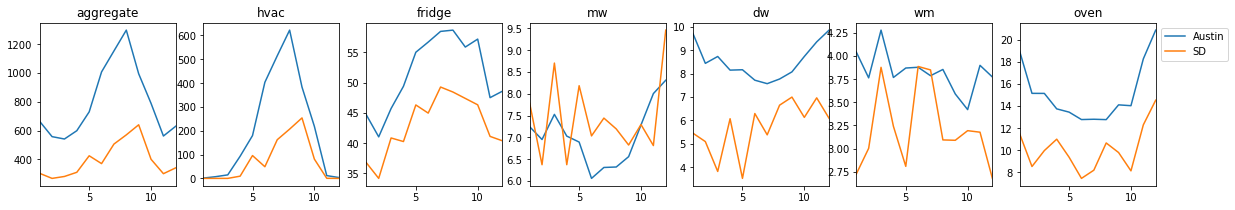

In [13]:
fig, ax = plt.subplots(ncols=7, figsize=(20, 3))
for col, appliance in enumerate(APPLIANCES_ORDER):
    
    au_appliance = au_df[['{}_{}'.format(appliance, month) for month in range(1, 13)]]
    au_appliance.columns = range(1, 13)
    au_appliance.mean().plot(ax=ax[col], title=appliance)
    
    sd_appliance = df[['{}_{}'.format(appliance, month) for month in range(1, 13)]]
    sd_appliance.columns = range(1, 13)
    sd_appliance.mean().plot(ax=ax[col])
plt.legend(['Austin','SD'], bbox_to_anchor=(1, 1))
    

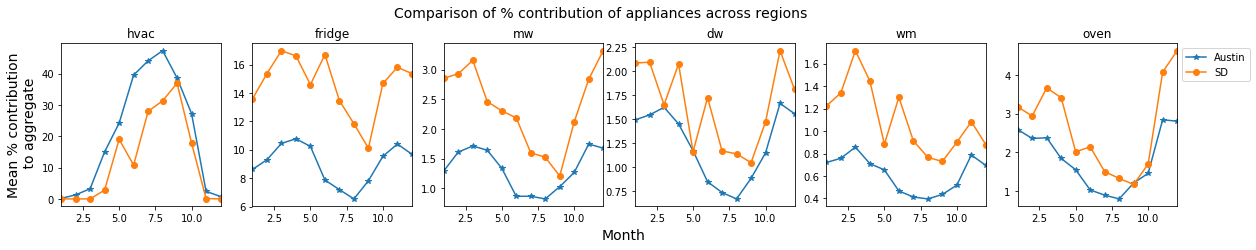

In [14]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 3))
for col, appliance in enumerate(APPLIANCES_ORDER[1:]):
    
    au_appliance = au_df[['{}_{}'.format(appliance, month) for month in range(1, 13)]]
    au_agg = au_df[['{}_{}'.format("aggregate", month) for month in range(1, 13)]]
    au_appliance.columns = range(1, 13)
    au_agg.columns = range(1, 13)
    mean_prop_au = (100*au_appliance/au_agg).mean()
    mean_prop_au.index = range(1, 13)
    mean_prop_au.plot(ax=ax[col], title=appliance,marker='*')
    
    sd_appliance = df[['{}_{}'.format(appliance, month) for month in range(1, 13)]]
    sd_agg = df[['{}_{}'.format("aggregate", month) for month in range(1, 13)]]

    sd_appliance.columns = range(1, 13)
    sd_agg.columns = range(1, 13)
    mean_prop_sd = (100*sd_appliance/sd_agg).mean()
    mean_prop_sd.index = range(1, 13)
    mean_prop_sd.plot(ax=ax[col], title=appliance, marker='o')

    #sd_appliance.mean().plot(ax=ax[col])
plt.legend(['Austin','SD'], bbox_to_anchor=(1, 1))
ax[0].set_ylabel("Mean % contribution\n to aggregate", fontsize=14)    
fig.text(0.5, -0.03, "Month", fontsize=14)
plt.suptitle("Comparison of % contribution of appliances across regions", fontsize=14, y=1.05)

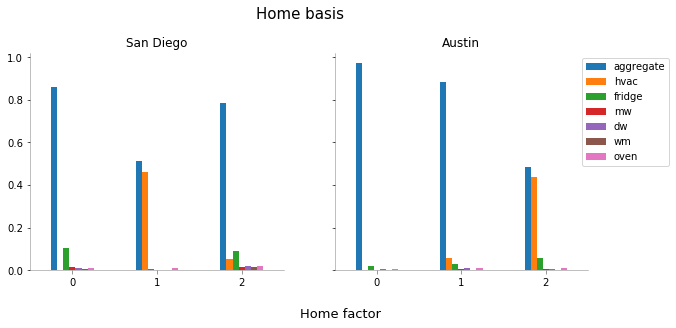

In [142]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
e = pd.DataFrame(np.einsum('ahs -> ah', A_sd), index=APPLIANCES_ORDER)
e.div(e.sum()).T.plot(kind='bar', ax=ax[0], rot=0, legend=False, title='San Diego')

e = pd.DataFrame(np.einsum('ahs -> ah', A_au), index=APPLIANCES_ORDER)
e.div(e.sum()).T.plot(kind='bar', ax=ax[1], rot=0,title='Austin')
plt.legend(bbox_to_anchor=(1.34,1))
format_axes(ax[0])
format_axes(ax[1])
fig.text( 0.5, -0.04 ,"Home factor", fontsize=(13))
plt.suptitle("Home basis", fontsize=(15), y=1.04)

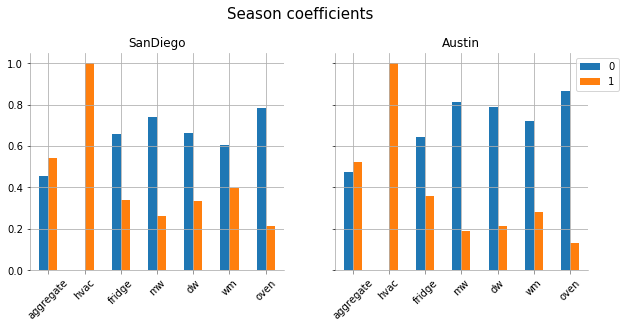

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))
e = pd.DataFrame(np.einsum('ahs -> as', A_sd), index=APPLIANCES_ORDER)
e.T.div(e.sum(axis=1)).T.plot(kind='bar', rot=45, ax=ax[0], title='SanDiego', legend=False)

e = pd.DataFrame(np.einsum('ahs -> as', A_au), index=APPLIANCES_ORDER)
e.T.div(e.sum(axis=1)).T.plot(kind='bar', rot=45, ax=ax[1],  title='Austin')

format_axes(ax[0])
format_axes(ax[1])
plt.suptitle("Season coefficients", fontsize=(15), y=1.04)
plt.legend(bbox_to_anchor=(1.14,1))
ax[0].grid()
ax[1].grid()



In [88]:
pd.DataFrame(np.einsum('ahs -> ah', A_sd), index=APPLIANCES_ORDER).T.div(pd.DataFrame(np.einsum('ahs -> ah', A_sd), index=APPLIANCES_ORDER).sum(axis=1)).T

,0,1,2
aggregate,0.384856,0.293437,0.321707
hvac,0.000713,0.924645,0.074642
fridge,0.530825,0.030822,0.438353
mw,0.415908,0.110922,0.473171
dw,0.319670,0.101053,0.579277
wm,0.208856,0.090773,0.700371
oven,0.252689,0.355677,0.391634


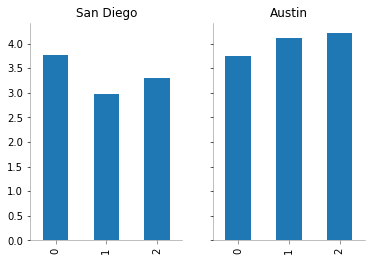

In [138]:
fig, ax = plt.subplots(ncols=2, sharey=True)
pd.DataFrame(H_sd).mean().plot(kind='bar', ax=ax[0], title='San Diego')
pd.DataFrame(H_au).mean().plot(kind='bar', ax=ax[1], title='Austin')
format_axes(ax[0])
format_axes(ax[1])

,0,1
aggregate,4.758684e+01,52.413165
hvac,2.676831e-07,100.000000
fridge,6.433948e+01,35.660524
mw,8.101162e+01,18.988380
dw,7.858780e+01,21.412199
wm,7.184940e+01,28.150603
oven,8.668156e+01,13.318443


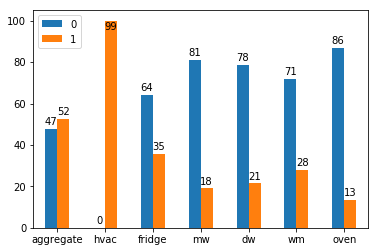

In [82]:
a_df = pd.DataFrame(np.einsum('ahs -> as', A_au), index=APPLIANCES_ORDER)
(a_df.T.div(a_df.sum(axis=1)).T*100).plot(kind='bar', rot=0)
ax = plt.gca()
autolabel(ax.patches,ax)
(a_df.T.div(a_df.sum(axis=1)).T*100)

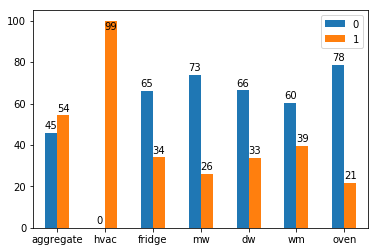

In [60]:
a_df = pd.DataFrame(np.einsum('ahs -> as', A_sd), index=APPLIANCES_ORDER)
(a_df.T.div(a_df.sum(axis=1)).T*100).plot(kind='bar', rot=0)
ax = plt.gca()
autolabel(ax.patches,ax)

In [63]:
pd.DataFrame(np.einsum('ahs -> ah', A_sd), index=APPLIANCES_ORDER)

,0,1,2
aggregate,11.735322,8.947712,9.809727
hvac,0.006218,8.065952,0.651127
fridge,1.398449,0.081201,1.154833
mw,0.191089,0.050963,0.217398
dw,0.131647,0.041616,0.238559
wm,0.056810,0.024691,0.190505
oven,0.150136,0.211327,0.232691


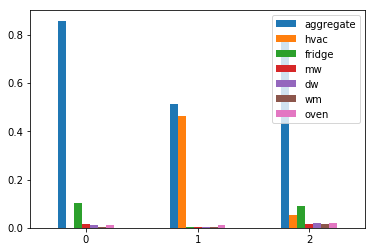

In [80]:
a_df = pd.DataFrame(np.einsum('ahs -> ah', A_sd), index=APPLIANCES_ORDER)
a_df.div(a_df.sum()).T.plot(kind='bar', rot=0)

In [107]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 3
TRAIN_SPLITS = range(10, 110, 40)
case = 2
num_home = 5
n_iter=1200

cost = 'l21'
algo = 'adagrad'
for static_fac in ['static',None]:
    if static_fac is None:
        H_known_Au = None
        H_known_Sd = None
    else:
        H_known_Au = static_au
        H_known_Sd = static_sd
    np.random.seed(0)
    pred[static_fac] = {}
    #for lam in [1e-2, 100]:
    for lam in [1e-3, 1e-2, 1e-1, 0, 1]:
        pred[static_fac][lam] = {}
        for a in range(2, 3):
            if static_fac is not None:
                H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, H_known=H_known_Au, penalty_coeff=lam)
            else:
                H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, penalty_coeff=lam)

            pred[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                pred[static_fac][lam][a][random_seed] = {}
                for appliance in APPLIANCES_ORDER:
                    pred[static_fac][lam][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

            kf = KFold(n_splits=n_splits)
            for random_seed in range(NUM_RANDOM):

                for train_percentage in TRAIN_SPLITS:
                    print(lam, static_fac, a, random_seed,train_percentage)
                    for train_max, test in kf.split(df):

                        num_train = int((train_percentage*len(train_max)/100)+0.5)
                        if train_percentage==100:
                            train = train_max
                        else:
                            train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                        train_ix = df.index[train]
                        test_ix = df.index[test]

                        num_test = len(test_ix)
                        train_test_ix = np.concatenate([test_ix, train_ix])
                        df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                        tensor = get_tensor(df_t, dfc_t)
                        tensor_copy = tensor.copy()
                        # First n
                        tensor_copy[:num_test, 1:, :] = np.NaN
                        if static_fac is not None:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, A_known=A_au, H_known=H_known_Sd[np.concatenate([test, train])],penalty_coeff=lam)
                        else:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, A_known=A_au, penalty_coeff=lam)

                        assert(np.allclose(A, A_au))
                        HAT = multiply_case(H, A, T, case)
                        for appliance in APPLIANCES_ORDER:
                            pred[static_fac][lam][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


(0.001, 'static', 2, 0, 10)


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


(0.001, 'static', 2, 0, 50)
(0.001, 'static', 2, 0, 90)
(0.001, 'static', 2, 1, 10)
(0.001, 'static', 2, 1, 50)
(0.001, 'static', 2, 1, 90)
(0.001, 'static', 2, 2, 10)
(0.001, 'static', 2, 2, 50)
(0.001, 'static', 2, 2, 90)
(0.01, 'static', 2, 0, 10)
(0.01, 'static', 2, 0, 50)
(0.01, 'static', 2, 0, 90)
(0.01, 'static', 2, 1, 10)
(0.01, 'static', 2, 1, 50)
(0.01, 'static', 2, 1, 90)
(0.01, 'static', 2, 2, 10)
(0.01, 'static', 2, 2, 50)
(0.01, 'static', 2, 2, 90)
(0.1, 'static', 2, 0, 10)
(0.1, 'static', 2, 0, 50)
(0.1, 'static', 2, 0, 90)
(0.1, 'static', 2, 1, 10)
(0.1, 'static', 2, 1, 50)
(0.1, 'static', 2, 1, 90)
(0.1, 'static', 2, 2, 10)
(0.1, 'static', 2, 2, 50)
(0.1, 'static', 2, 2, 90)
(0, 'static', 2, 0, 10)
(0, 'static', 2, 0, 50)
(0, 'static', 2, 0, 90)
(0, 'static', 2, 1, 10)
(0, 'static', 2, 1, 50)
(0, 'static', 2, 1, 90)
(0, 'static', 2, 2, 10)
(0, 'static', 2, 2, 50)
(0, 'static', 2, 2, 90)
(1, 'static', 2, 0, 10)
(1, 'static', 2, 0, 50)
(1, 'static', 2, 0, 90)
(1, 'static

In [109]:
from common import compute_rmse_fraction

In [110]:
out = {}
algo = 'adagrad'
for static_fac in ['static',None]:
    out[static_fac] = {}
    for lam in [1e-3, 1e-2, 1e-1, 0, 1]:
        out[static_fac][lam] = {}
        for a in range(2, 3):
            out[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                out[static_fac][lam][a][random_seed] = {}

                for appliance in APPLIANCES_ORDER[1:]:
                    out[static_fac][lam][a][random_seed][appliance] = {}
                    for f in TRAIN_SPLITS:
                        s = pd.concat(pred[static_fac][lam][a][random_seed][appliance][f]).ix[df.index]
                        if appliance=="hvac":
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [111]:
out[None].keys()

[0, 1, 0.001, 0.1, 0.01]

In [112]:
pd.DataFrame(out[None][0][2][0])

,dw,fridge,hvac,mw,oven,wm
10,1.860455,10.935846,18.856767,2.251195,2.352933,0.931564
50,1.854274,10.784018,15.459790,2.216260,2.279772,0.929652
90,1.852848,10.579758,15.530935,2.219273,2.244295,0.925171


In [113]:
import pickle
pickle.dump(out, open('predictions/transfer-sparse-static-normalised.pkl','w'))

5.94878516424
5.40495528557
5.32077769842
5.36810957007
6.06490163948


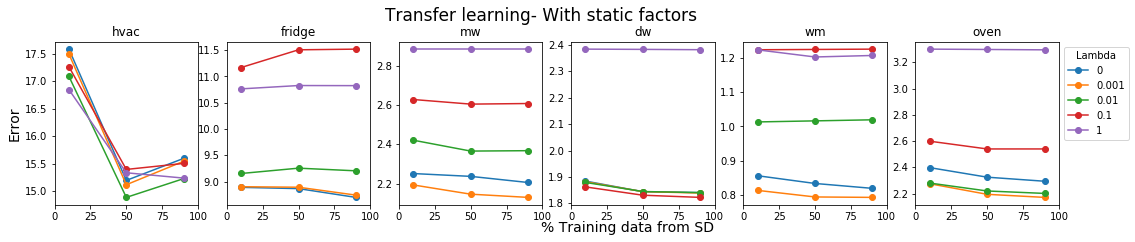

In [114]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [0, 1e-3, 1e-2, 1e-1, 1]:
    static_res[lam] = pd.Panel(out['static'][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([0, 1e-3, 1e-2, 1e-1, 1], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)
plt.suptitle("Transfer learning- With static factors", fontsize=17,y=1.04)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
print static_res[1].mean().mean()

5.59798547761
5.75660077884
5.78114127442
5.74000250781
5.6977433852


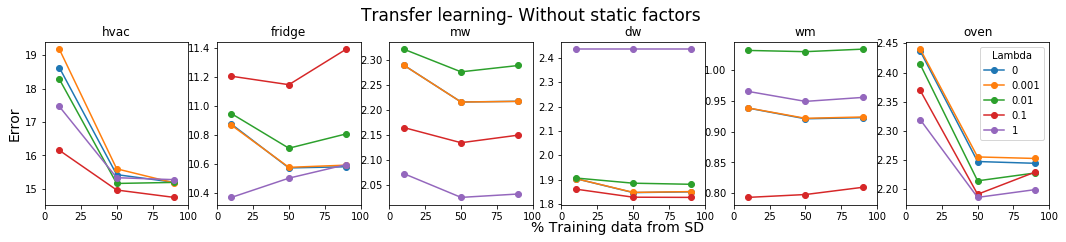

In [115]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [0, 1e-3, 1e-2, 1e-1, 1]:
    static_res[lam] = pd.Panel(out[None][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([0, 1e-3, 1e-2, 1e-1, 1], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)
plt.suptitle("Transfer learning- Without static factors", fontsize=17,y=1.04)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
print static_res[1].mean().mean()